<a href="https://colab.research.google.com/github/amsc101/ICU/blob/master/ICU_Mortality_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ICU Mortality Prediction

In [0]:
# Import libraries
import numpy as np
import matplotlib
import scipy.stats as ss
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from plotly.offline import init_notebook_mode,iplot
import plotly.graph_objects as go
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier

#### 1. Data visualitation 

In [0]:
"""from google.colab import drive
drive.mount('/content/drive', force_remount=True)"""

"from google.colab import drive\ndrive.mount('/content/drive', force_remount=True)"

In [0]:
"""data = pd.read_csv("/content/drive/My Drive/PROCESADO MASIVO/training_v2.csv",sep=',')
data.head()"""

'data = pd.read_csv("/content/drive/My Drive/PROCESADO MASIVO/training_v2.csv",sep=\',\')\ndata.head()'

In [0]:
data = pd.read_csv("training_v2.csv")
y=data['hospital_death']
data.head()

encounter_id  patient_id  hospital_id  hospital_death   age    bmi  \
0         66154       25312          118               0  68.0  22.73   
1        114252       59342           81               0  77.0  27.42   
2        119783       50777          118               0  25.0  31.95   
3         79267       46918          118               0  81.0  22.64   
4         92056       34377           33               0  19.0    NaN   

   elective_surgery  ethnicity gender  height  ... aids cirrhosis  \
0                 0  Caucasian      M   180.3  ...  0.0       0.0   
1                 0  Caucasian      F   160.0  ...  0.0       0.0   
2                 0  Caucasian      F   172.7  ...  0.0       0.0   
3                 1  Caucasian      F   165.1  ...  0.0       0.0   
4                 0  Caucasian      M   188.0  ...  0.0       0.0   

   diabetes_mellitus hepatic_failure immunosuppression  leukemia  lymphoma  \
0                1.0             0.0               0.0       0.0       0.0   
1                1.0             0.0               0.0       0.0       0.0   
2                0.0             0.0               0.0       0.0       0.0   
3                0.0             0.0               0.0       0.0       0.0   
4                0.0             0.0               0.0       0.0       0.0   

   solid_tumor_with_metastasis  apache_3j_bodysystem  apache_2_bodysystem  
0                          0.0                Sepsis       Cardiovascular  
1                          0.0           Respiratory          Respiratory  
2                          0.0             Metabolic            Metabolic  
3                          0.0        Cardiovascular       Cardiovascular  
4                          0.0                Trauma               Trauma  

[5 rows x 186 columns]

In [0]:
type(data['hospital_death'][0])

numpy.int64

In [0]:
print('nº of variables : ', data.shape[1],'\nnº of patients: ', data.shape[0])

nº of variables :  186 
nº of patients:  91713


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Columns: 186 entries, encounter_id to apache_2_bodysystem
dtypes: float64(170), int64(8), object(8)
memory usage: 130.1+ MB


In [0]:
df = data[data.columns[0:20]]
df.isna().sum()

encounter_id                 0
patient_id                   0
hospital_id                  0
hospital_death               0
age                       4228
bmi                       3429
elective_surgery             0
ethnicity                 1395
gender                      25
height                    1334
hospital_admit_source    21409
icu_admit_source           112
icu_id                       0
icu_stay_type                0
icu_type                     0
pre_icu_los_days             0
readmission_status           0
weight                    2720
albumin_apache           54379
apache_2_diagnosis        1662
dtype: int64

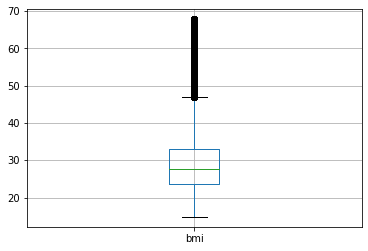

In [0]:
data.boxplot(column='bmi')

los outliers socorro

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B128FB1688>]],
      dtype=object)

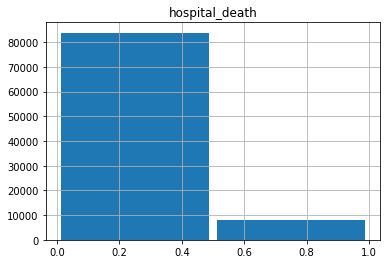

In [0]:
data.hist(column='hospital_death', bins=2, rwidth=0.95)

#### More correlated with target variables

In [0]:
cor = data.corr()

In [0]:
cor_target = abs(cor["hospital_death"])

In [0]:
relevant_features = cor_target[cor_target>0.2]
relevant_features = relevant_features.sort_values(ascending=False)[0:11]
relevant_features

hospital_death                   1.000000
d1_lactate_min                   0.403614
d1_lactate_max                   0.399029
h1_lactate_min                   0.344046
h1_lactate_max                   0.340951
apache_4a_hospital_death_prob    0.311043
apache_4a_icu_death_prob         0.283913
gcs_motor_apache                 0.282449
gcs_eyes_apache                  0.260373
gcs_verbal_apache                0.241044
d1_sysbp_invasive_min            0.234382
Name: hospital_death, dtype: float64

In [0]:
relevant_feat_names =['d1_lactate_min','d1_lactate_max','h1_lactate_min','h1_lactate_max','apache_4a_hospital_death_prob','apache_4a_icu_death_prob','gcs_motor_apache','gcs_eyes_apache','gcs_verbal_apache']

In [0]:
relevant_feat= data[relevant_feat_names]

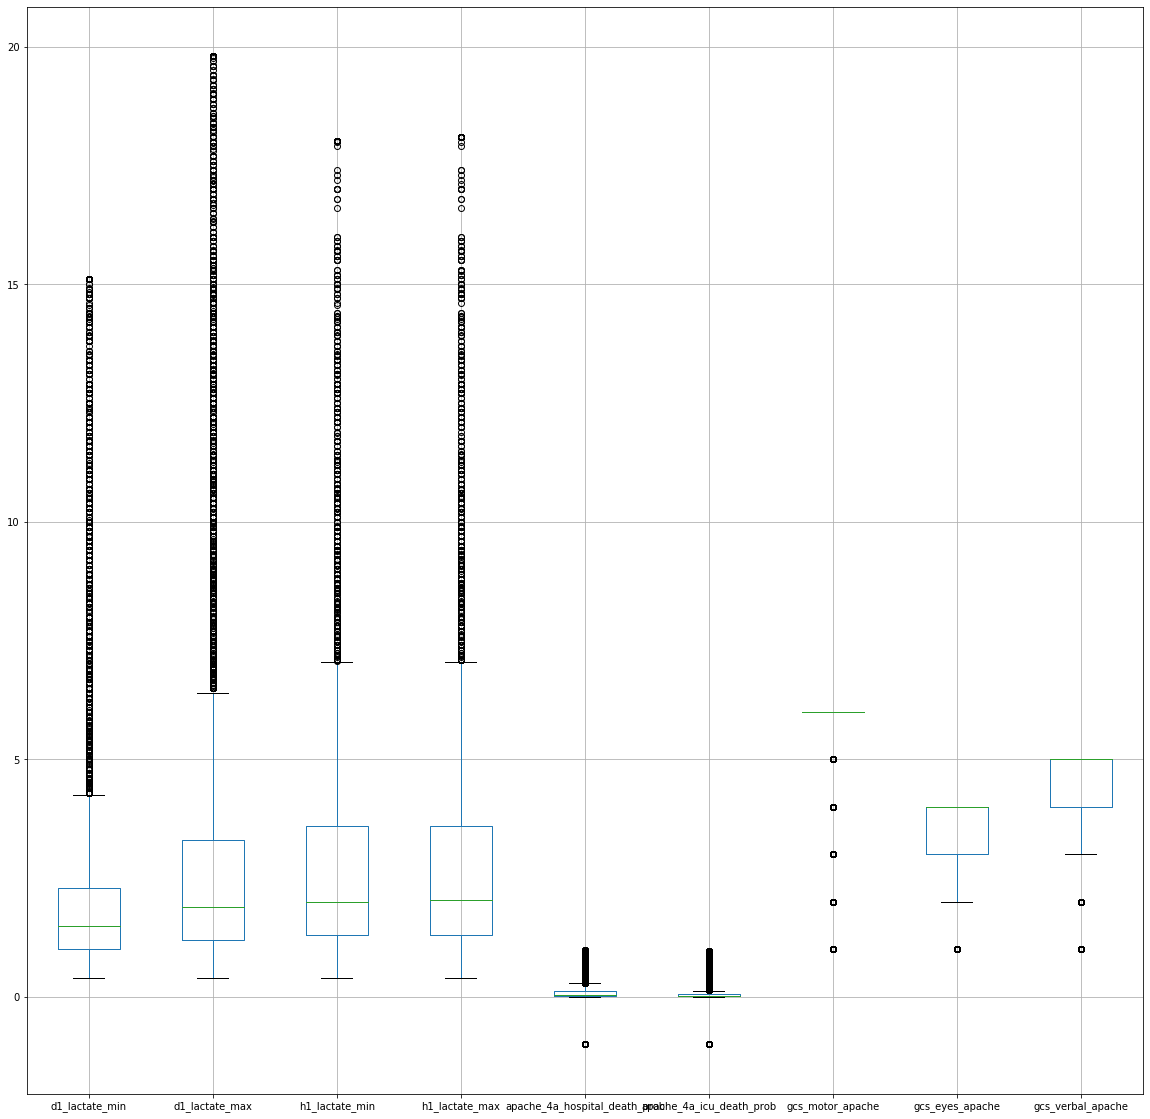

In [0]:
relevant_feat.boxplot(figsize=(20,20))

In [0]:
#valores negativos 
#colas largas

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B12B1B0B88>,
      dtype=object)

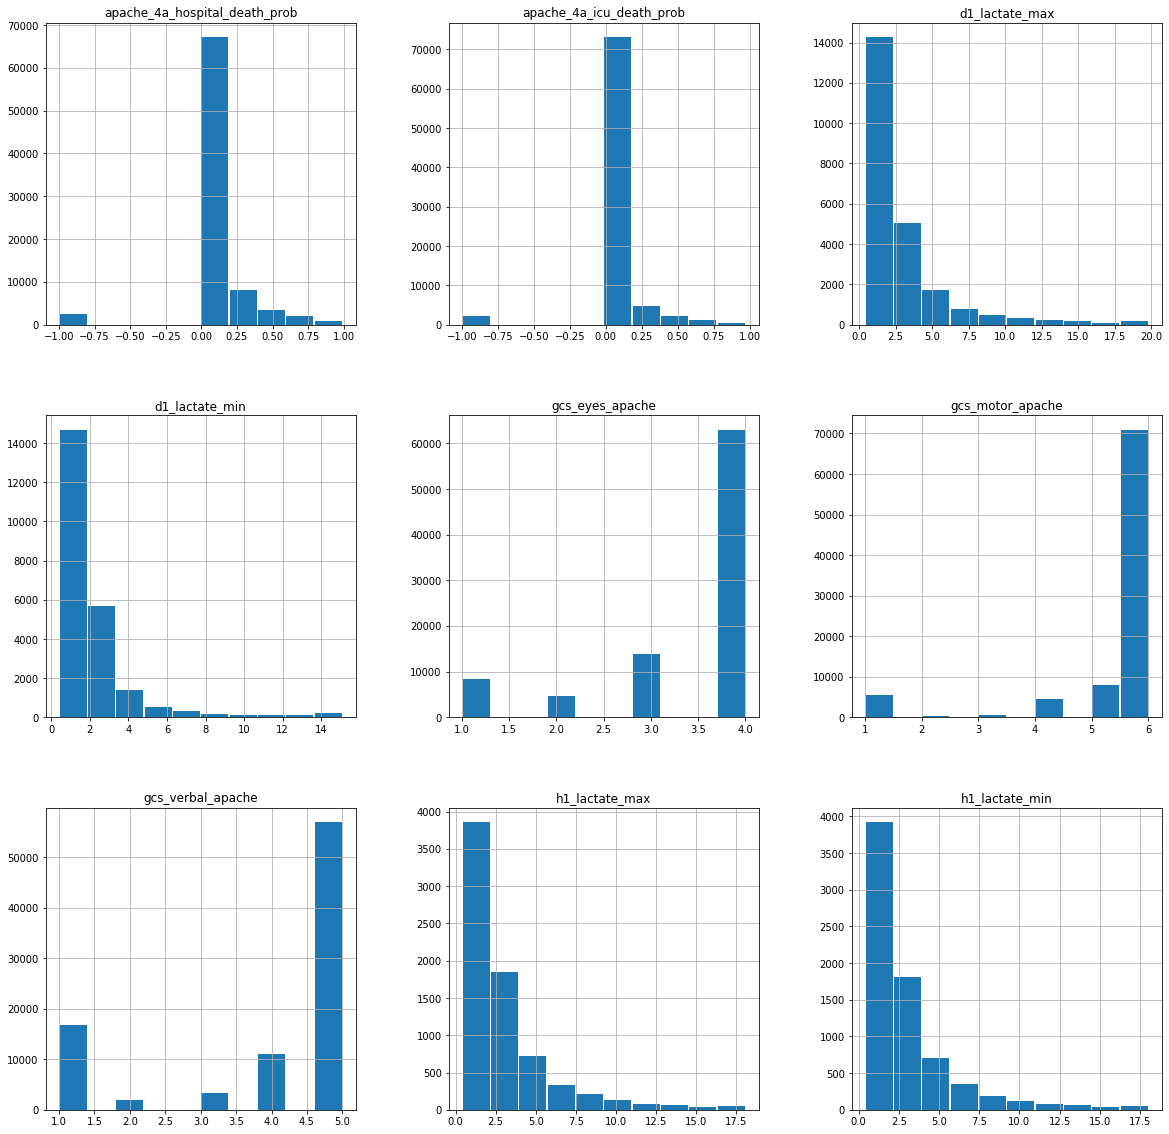

In [0]:
relevant_feat.hist(rwidth=0.95,figsize=(20,20))

#### Categorical data

In [0]:
#categorical_cols =  ['hospital_id', 'ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'apache_3j_bodysystem', 'apache_2_bodysystem',"hospital_death","d1_heartrate_min" ,"d1_resprate_min"]

categorical_cols = data.select_dtypes(exclude=['float']).columns
categorical_cols

Index(['encounter_id', 'patient_id', 'hospital_id', 'hospital_death',
       'elective_surgery', 'ethnicity', 'gender', 'hospital_admit_source',
       'icu_admit_source', 'icu_id', 'icu_stay_type', 'icu_type',
       'readmission_status', 'apache_post_operative', 'apache_3j_bodysystem',
       'apache_2_bodysystem'],
      dtype='object')

In [0]:
data['d1_resprate_min'].dtype

dtype('float64')

In [0]:
Categorical_df= data[categorical_cols]
Categorical_df.head()

encounter_id  patient_id  hospital_id  hospital_death  elective_surgery  \
0         66154       25312          118               0                 0   
1        114252       59342           81               0                 0   
2        119783       50777          118               0                 0   
3         79267       46918          118               0                 1   
4         92056       34377           33               0                 0   

   ethnicity gender hospital_admit_source           icu_admit_source  icu_id  \
0  Caucasian      M                 Floor                      Floor      92   
1  Caucasian      F                 Floor                      Floor      90   
2  Caucasian      F  Emergency Department       Accident & Emergency      93   
3  Caucasian      F        Operating Room  Operating Room / Recovery      92   
4  Caucasian      M                   NaN       Accident & Emergency      91   

  icu_stay_type      icu_type  readmission_status  apache_post_operative  \
0         admit         CTICU                   0                      0   
1         admit  Med-Surg ICU                   0                      0   
2         admit  Med-Surg ICU                   0                      0   
3         admit         CTICU                   0                      1   
4         admit  Med-Surg ICU                   0                      0   

  apache_3j_bodysystem apache_2_bodysystem  
0               Sepsis      Cardiovascular  
1          Respiratory         Respiratory  
2            Metabolic           Metabolic  
3       Cardiovascular      Cardiovascular  
4               Trauma              Trauma

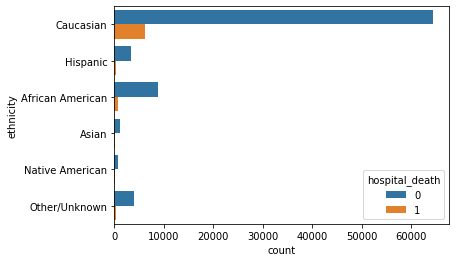

In [0]:
sns.countplot(y="ethnicity", hue="hospital_death" , data=Categorical_df);

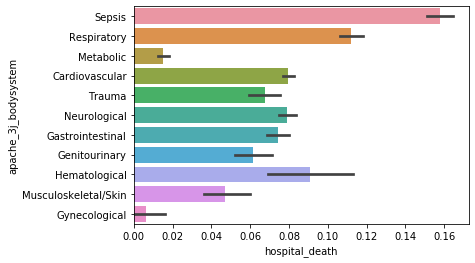

In [0]:
sns.barplot(y="apache_3j_bodysystem", x="hospital_death" , data=Categorical_df);

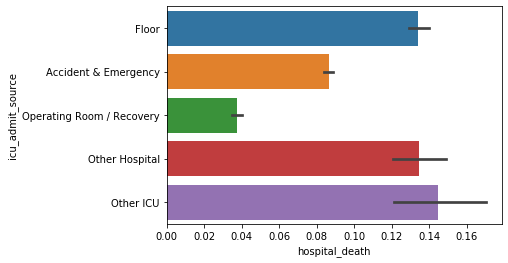

In [0]:
sns.barplot(x="hospital_death", y="icu_admit_source" , data=Categorical_df);

In [0]:
#labels
lab = df["hospital_admit_source"].value_counts().keys().tolist()
#values
val = df["hospital_admit_source"].value_counts().values.tolist()
trace = go.Pie(labels=lab, 
                values=val, 
                marker=dict(colors=['Pink']), 
                # Seting values to 
                hoverinfo="value")
data_var = [trace]
layout = go.Layout(title="Hospital Admit Source")
fig = go.Figure(data = data_var,layout = layout)
iplot(fig)

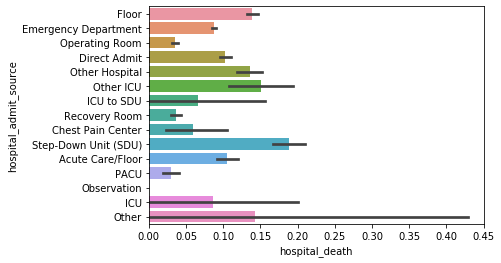

In [0]:
sns.barplot(y="hospital_admit_source", x="hospital_death" , data=data);

#### Missing values

Hay un porron

In [0]:
data.isna().sum().sum()

5743492

In [0]:
data['hospital_death']

0        0
1        0
2        0
3        0
4        0
        ..
91708    0
91709    0
91710    0
91711    0
91712    0
Name: hospital_death, Length: 91713, dtype: int64

In [0]:
data=data.drop(['hospital_death'], axis=1)

1.  Drop the variable if it has more than 50% missing values

In [0]:
threshold = len(data) * 0.60
df_thresh=data.dropna(axis=1, thresh=threshold)
df_thresh.shape

(91713, 111)

In [0]:
df_thresh.isna().sum().sum()

589721

In [0]:
pre_data=df_thresh
pre_data.shape,data.shape

((91713, 111), (91713, 185))

In [0]:
# Documentar las decisiones 
#grafica con porcentaje los valores nulos

2. Categorical variables

In [0]:
categorical_cols = data.select_dtypes(exclude=['float']).columns
Categorical_df= pre_data[np.array(categorical_cols)]

In [0]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
Categorical_df = imp.fit_transform(Categorical_df)

In [0]:
Categorical_df = pd.DataFrame(Categorical_df)
Categorical_df.columns = np.array(categorical_cols)
Categorical_df.isna().sum().sum()

0

3. Numerical variables

In [0]:
numerical_cols = pre_data.select_dtypes(include=['float']).columns
numerical_cols

Numerical_df= pre_data[numerical_cols]

In [0]:
imp = SimpleImputer(missing_values=np.nan, strategy='median')
Numerical_df = imp.fit_transform(Numerical_df)

In [0]:
Numerical_df = pd.DataFrame(Numerical_df)
Numerical_df.columns = np.array(numerical_cols)
Numerical_df.isna().sum().sum()

0

In [0]:
Numerical_df.shape,Categorical_df.shape,pre_data.shape

((91713, 96), (91713, 15), (91713, 111))

Uno los dataframe de los numerical data y categorical data sin Nan

In [0]:
pre_data=pd.concat([Numerical_df, Categorical_df],axis=1)

In [0]:
pre_data.isna().sum().sum()

0

#### Unique variables
No aportan valor estadistico

In [0]:
print(pre_data.shape)
display(pre_data.nunique())

(91713, 111)


age                         74
bmi                      34888
height                     401
pre_icu_los_days          9757
weight                    3409
                         ...  
icu_type                     8
readmission_status           1
apache_post_operative        2
apache_3j_bodysystem        11
apache_2_bodysystem         10
Length: 111, dtype: int64

In [0]:
for c in pre_data.columns:
    if pre_data.shape[0]==pre_data[c].nunique():
        print(c)

encounter_id
patient_id


In [0]:
pre_data.drop(['encounter_id', 'patient_id'], axis='columns', inplace=True)

In [0]:
pre_data.shape, data.shape

((91713, 109), (91713, 185))

In [0]:
pre_data.head()

age        bmi  height  pre_icu_los_days  weight  apache_2_diagnosis  \
0  68.0  22.730000   180.3          0.541667    73.9               113.0   
1  77.0  27.420000   160.0          0.927778    70.2               108.0   
2  25.0  31.950000   172.7          0.000694    95.3               122.0   
3  81.0  22.640000   165.1          0.000694    61.7               203.0   
4  19.0  27.654655   188.0          0.073611    80.3               119.0   

   apache_3j_diagnosis  arf_apache  bun_apache  creatinine_apache  ...  \
0               502.01         0.0        31.0               2.51  ...   
1               203.01         0.0         9.0               0.56  ...   
2               703.03         0.0        19.0               0.98  ...   
3              1206.03         0.0        19.0               0.98  ...   
4               601.01         0.0        19.0               0.98  ...   

   gender  hospital_admit_source           icu_admit_source  icu_id  \
0       M                  Floor                      Floor      92   
1       F                  Floor                      Floor      90   
2       F   Emergency Department       Accident & Emergency      93   
3       F         Operating Room  Operating Room / Recovery      92   
4       M   Emergency Department       Accident & Emergency      91   

   icu_stay_type      icu_type  readmission_status  apache_post_operative  \
0          admit         CTICU                   0                      0   
1          admit  Med-Surg ICU                   0                      0   
2          admit  Med-Surg ICU                   0                      0   
3          admit         CTICU                   0                      1   
4          admit  Med-Surg ICU                   0                      0   

   apache_3j_bodysystem  apache_2_bodysystem  
0                Sepsis       Cardiovascular  
1           Respiratory          Respiratory  
2             Metabolic            Metabolic  
3        Cardiovascular       Cardiovascular  
4                Trauma               Trauma  

[5 rows x 109 columns]

#### Ver variables 

In [0]:
pre_data.columns[:36]

Index(['age', 'bmi', 'height', 'pre_icu_los_days', 'weight',
       'apache_2_diagnosis', 'apache_3j_diagnosis', 'arf_apache', 'bun_apache',
       'creatinine_apache', 'gcs_eyes_apache', 'gcs_motor_apache',
       'gcs_unable_apache', 'gcs_verbal_apache', 'glucose_apache',
       'heart_rate_apache', 'hematocrit_apache', 'intubated_apache',
       'map_apache', 'resprate_apache', 'sodium_apache', 'temp_apache',
       'ventilated_apache', 'wbc_apache', 'd1_diasbp_max', 'd1_diasbp_min',
       'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min',
       'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min',
       'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max',
       'd1_resprate_min'],
      dtype='object')

In [0]:
pre_data.columns[36:73]

Index(['d1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min',
       'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max',
       'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_min',
       'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min',
       'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_max', 'h1_mbp_min',
       'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_resprate_max',
       'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min', 'h1_sysbp_max',
       'h1_sysbp_min', 'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min',
       'h1_temp_max', 'h1_temp_min', 'd1_bun_max', 'd1_bun_min',
       'd1_calcium_max', 'd1_calcium_min', 'd1_creatinine_max',
       'd1_creatinine_min', 'd1_glucose_max', 'd1_glucose_min', 'd1_hco3_max'],
      dtype='object')

In [0]:
pre_data.columns[73:111]

Index(['d1_hco3_min', 'd1_hemaglobin_max', 'd1_hemaglobin_min',
       'd1_hematocrit_max', 'd1_hematocrit_min', 'd1_platelets_max',
       'd1_platelets_min', 'd1_potassium_max', 'd1_potassium_min',
       'd1_sodium_max', 'd1_sodium_min', 'd1_wbc_max', 'd1_wbc_min',
       'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', 'aids',
       'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
       'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis', 'hospital_id', 'elective_surgery',
       'ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source',
       'icu_id', 'icu_stay_type', 'icu_type', 'readmission_status',
       'apache_post_operative', 'apache_3j_bodysystem', 'apache_2_bodysystem'],
      dtype='object')

In [0]:
36+36+37

109

In [0]:
pre_data.columns

Index(['age', 'bmi', 'height', 'pre_icu_los_days', 'weight',
       'apache_2_diagnosis', 'apache_3j_diagnosis', 'arf_apache', 'bun_apache',
       'creatinine_apache',
       ...
       'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_id',
       'icu_stay_type', 'icu_type', 'readmission_status',
       'apache_post_operative', 'apache_3j_bodysystem', 'apache_2_bodysystem'],
      dtype='object', length=109)

Hay muchos en todas las variables 

#### Hot Encoding

In [0]:
'''
clean_data.columns
len(clean_data.columns)
'''

pre_data.columns

Index(['age', 'bmi', 'height', 'pre_icu_los_days', 'weight',
       'apache_2_diagnosis', 'apache_3j_diagnosis', 'arf_apache', 'bun_apache',
       'creatinine_apache',
       ...
       'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_id',
       'icu_stay_type', 'icu_type', 'readmission_status',
       'apache_post_operative', 'apache_3j_bodysystem', 'apache_2_bodysystem'],
      dtype='object', length=109)

In [0]:
"""variables = []
for i in range(110):
  variables.append(clean_data.columns[i][0])
print(variables)"""

'variables = []\nfor i in range(110):\n  variables.append(clean_data.columns[i][0])\nprint(variables)'

In [0]:
'''clean_data.columns'''

'clean_data.columns'

In [0]:
'''clean_data.head()'''
pre_data.head()

age        bmi  height  pre_icu_los_days  weight  apache_2_diagnosis  \
0  68.0  22.730000   180.3          0.541667    73.9               113.0   
1  77.0  27.420000   160.0          0.927778    70.2               108.0   
2  25.0  31.950000   172.7          0.000694    95.3               122.0   
3  81.0  22.640000   165.1          0.000694    61.7               203.0   
4  19.0  27.654655   188.0          0.073611    80.3               119.0   

   apache_3j_diagnosis  arf_apache  bun_apache  creatinine_apache  ...  \
0               502.01         0.0        31.0               2.51  ...   
1               203.01         0.0         9.0               0.56  ...   
2               703.03         0.0        19.0               0.98  ...   
3              1206.03         0.0        19.0               0.98  ...   
4               601.01         0.0        19.0               0.98  ...   

   gender  hospital_admit_source           icu_admit_source  icu_id  \
0       M                  Floor                      Floor      92   
1       F                  Floor                      Floor      90   
2       F   Emergency Department       Accident & Emergency      93   
3       F         Operating Room  Operating Room / Recovery      92   
4       M   Emergency Department       Accident & Emergency      91   

   icu_stay_type      icu_type  readmission_status  apache_post_operative  \
0          admit         CTICU                   0                      0   
1          admit  Med-Surg ICU                   0                      0   
2          admit  Med-Surg ICU                   0                      0   
3          admit         CTICU                   0                      1   
4          admit  Med-Surg ICU                   0                      0   

   apache_3j_bodysystem  apache_2_bodysystem  
0                Sepsis       Cardiovascular  
1           Respiratory          Respiratory  
2             Metabolic            Metabolic  
3        Cardiovascular       Cardiovascular  
4                Trauma               Trauma  

[5 rows x 109 columns]

In [0]:
categorical_cols = data.select_dtypes(exclude=['float']).columns

In [0]:
categorical_cols

Index(['encounter_id', 'patient_id', 'hospital_id', 'elective_surgery',
       'ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source',
       'icu_id', 'icu_stay_type', 'icu_type', 'readmission_status',
       'apache_post_operative', 'apache_3j_bodysystem', 'apache_2_bodysystem'],
      dtype='object')

In [0]:
categoricas = []
for i in categorical_cols:
  categoricas.append(i)
categoricas.remove('encounter_id')
categoricas.remove('patient_id')

categoricas

['hospital_id',
 'elective_surgery',
 'ethnicity',
 'gender',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_id',
 'icu_stay_type',
 'icu_type',
 'readmission_status',
 'apache_post_operative',
 'apache_3j_bodysystem',
 'apache_2_bodysystem']

In [0]:
one_hot_enconding = []
'''for i in categoricas:
  one_hot_enconding.append(pd.get_dummies(clean_data[i], prefix = i))'''
for i in categoricas:
  one_hot_enconding.append(pd.get_dummies(pre_data[i], prefix = i))

In [0]:
#Meter todas las variables a mano que haya que hacer One Hot Encoding

In [0]:
for i in one_hot_enconding:
  clean_data = pd.concat([pre_data, i], axis=1)

In [0]:
list(clean_data)

['age',
 'bmi',
 'height',
 'pre_icu_los_days',
 'weight',
 'apache_2_diagnosis',
 'apache_3j_diagnosis',
 'arf_apache',
 'bun_apache',
 'creatinine_apache',
 'gcs_eyes_apache',
 'gcs_motor_apache',
 'gcs_unable_apache',
 'gcs_verbal_apache',
 'glucose_apache',
 'heart_rate_apache',
 'hematocrit_apache',
 'intubated_apache',
 'map_apache',
 'resprate_apache',
 'sodium_apache',
 'temp_apache',
 'ventilated_apache',
 'wbc_apache',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_diasbp_noninvasive_max',
 'd1_diasbp_noninvasive_min',
 'd1_heartrate_max',
 'd1_heartrate_min',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_mbp_noninvasive_max',
 'd1_mbp_noninvasive_min',
 'd1_resprate_max',
 'd1_resprate_min',
 'd1_spo2_max',
 'd1_spo2_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_sysbp_noninvasive_max',
 'd1_sysbp_noninvasive_min',
 'd1_temp_max',
 'd1_temp_min',
 'h1_diasbp_max',
 'h1_diasbp_min',
 'h1_diasbp_noninvasive_max',
 'h1_diasbp_noninvasive_min',
 'h1_heartrate_max',
 'h1_heartrate_min',
 'h1_mbp_ma

In [0]:
for i in categoricas:
  del clean_data[i] #Borramos las variables sueltas

In [0]:
clean_data

age        bmi  height  pre_icu_los_days  weight  apache_2_diagnosis  \
0      68.0  22.730000   180.3          0.541667    73.9               113.0   
1      77.0  27.420000   160.0          0.927778    70.2               108.0   
2      25.0  31.950000   172.7          0.000694    95.3               122.0   
3      81.0  22.640000   165.1          0.000694    61.7               203.0   
4      19.0  27.654655   188.0          0.073611    80.3               119.0   
...     ...        ...     ...               ...     ...                 ...   
91708  75.0  23.060250   177.8          0.298611    72.9               113.0   
91709  56.0  47.179671   183.0          0.120139   158.0               113.0   
91710  48.0  27.236914   170.2          0.046528    78.9               123.0   
91711  65.0  23.297481   154.9          0.081944    55.9               108.0   
91712  82.0  22.031250   160.0          0.018056    56.4               304.0   

       apache_3j_diagnosis  arf_apache  bun_apache  creatinine_apache  ...  \
0                   502.01         0.0        31.0               2.51  ...   
1                   203.01         0.0         9.0               0.56  ...   
2                   703.03         0.0        19.0               0.98  ...   
3                  1206.03         0.0        19.0               0.98  ...   
4                   601.01         0.0        19.0               0.98  ...   
...                    ...         ...         ...                ...  ...   
91708               501.06         0.0        19.0               0.98  ...   
91709               501.05         0.0        34.0               2.30  ...   
91710               702.01         0.0        33.0               2.30  ...   
91711               203.01         0.0        19.0               0.98  ...   
91712              1409.02         0.0        27.0               1.50  ...   

       apache_2_bodysystem_Cardiovascular  \
0                                       1   
1                                       0   
2                                       0   
3                                       1   
4                                       0   
...                                   ...   
91708                                   1   
91709                                   1   
91710                                   0   
91711                                   0   
91712                                   0   

       apache_2_bodysystem_Gastrointestinal  apache_2_bodysystem_Haematologic  \
0                                         0                                 0   
1                                         0                                 0   
2                                         0                                 0   
3                                         0                                 0   
4                                         0                                 0   
...                                     ...                               ...   
91708                                     0                                 0   
91709                                     0                                 0   
91710                                     0                                 0   
91711                                     0                                 0   
91712                                     1                                 0   

       apache_2_bodysystem_Metabolic  apache_2_bodysystem_Neurologic  \
0                                  0                               0   
1                                  0                               0   
2                                  1                               0   
3                                  0                               0   
4                                  0                               0   
...                              ...                             ...   
91708                              0                               0   
91709               

In [0]:
for i in clean_data.columns:
    if 'hospital' in i:
        print (i)

apache_4a_hospital_death_prob


In [0]:
#### Atribute Selection 

#### Fearure importance

In [0]:
X=clean_data
len(X.columns)

106

In [0]:
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = X.corr().abs()
corr_matrix.head()

age       bmi    height  pre_icu_los_days    weight  \
age               1.000000  0.086472  0.108982          0.048416  0.126515   
bmi               0.086472  1.000000  0.055648          0.001124  0.873599   
height            0.108982  0.055648  1.000000          0.008154  0.385645   
pre_icu_los_days  0.048416  0.001124  0.008154          1.000000  0.004235   
weight            0.126515  0.873599  0.385645          0.004235  1.000000   

                  apache_2_diagnosis  apache_3j_diagnosis  arf_apache  \
age                         0.020766             0.056479    0.002590   
bmi                         0.024247             0.006238    0.005708   
height                      0.002018             0.015052    0.010361   
pre_icu_los_days            0.080678             0.088844    0.048101   
weight                      0.025056             0.000427    0.010612   

                  bun_apache  creatinine_apache  ...  \
age                 0.206649           0.050835  ...   
bmi                 0.042388           0.060039  ...   
height              0.017410           0.051966  ...   
pre_icu_los_days    0.036998           0.024071  ...   
weight              0.045813           0.077660  ...   

                  apache_2_bodysystem_Cardiovascular  \
age                                         0.155293   
bmi                                         0.038734   
height                                      0.000994   
pre_icu_los_days                            0.008601   
weight                                      0.037727   

                  apache_2_bodysystem_Gastrointestinal  \
age                                           0.050252   
bmi                                           0.022638   
height                                        0.010540   
pre_icu_los_days                              0.037151   
weight                                        0.025820   

                  apache_2_bodysystem_Haematologic  \
age                                       0.005158   
bmi                                       0.007969   
height                                    0.010709   
pre_icu_los_days                          0.003090   
weight                                    0.013528   

                  apache_2_bodysystem_Metabolic  \
age                                    0.286280   
bmi                                    0.048204   
height                                 0.014138   
pre_icu_los_days                       0.066305   
weight                                 0.039829   

                  apache_2_bodysystem_Neurologic  \
age                                     0.008042   
bmi                                     0.025929   
height                                  0.013223   
pre_icu_los_days                        0.038514   
weight                                  0.029747   

                  apache_2_bodysystem_Renal/Genitourinary  \
age                                              0.030091   
bmi                                              0.039787   
height                                           0.027643   
pre_icu_los_days                                 0.006073   
weight                                           0.024529   

                  apache_2_bodysystem_Respiratory  apache_2_bodysystem_Trauma  \
age                                      0.024166                    0.083385   
bmi                                      0.018304                    0.048079   
height                                   0.025436                    0.041779   
pre_icu_los_days                         0.047278                    0.044351   
weight                                   0.005475                    0.027235   

                  apache_2_bodysystem_Undefined Diagnoses  \
age                                              0.028262   
bmi                                              0.017027   
height                                           0.004935   
pre_icu_los_days                                 

In [0]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('There are %d columns to remove.' % (len(to_drop)))
#Drop the columns with high correlations
X = X.drop(columns = to_drop)

There are 22 columns to remove.


In [0]:
# Train missing values (in percent)
train_missing = (X.isnull().sum() / len(X)).sort_values(ascending = False)
train_missing.head()
train_missing = train_missing.index[train_missing > 0.75]
print('There are %d columns with more than 75%% missing values' % len(train_missing))
X = X.drop(columns = train_missing)

There are 0 columns with more than 75% missing values


In [0]:
len(X.columns)

84

In [0]:
#X = pd.get_dummies(X)

In [0]:
len(X.columns)

84

In [0]:
feature_importances = np.zeros(X.shape[1])


In [0]:
import lightgbm as lgb

model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [0]:
for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(X, y, test_size = 0.25, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)],eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += model.feature_importances_

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[92]	valid_0's auc: 0.894455	valid_0's binary_logloss: 0.359387
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.889625	valid_0's binary_logloss: 0.319549
Early stopping, best iteration is:
[149]	valid_0's auc: 0.890833	valid_0's binary_logloss: 0.336887


In [0]:
len(X.columns),len(train_features.columns),len(valid_features.columns),len(feature_importances)

(84, 84, 84, 84)

In [0]:
#feature_importances

In [0]:
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(X.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
feature_importances.head()

feature  importance
64  apache_4a_hospital_death_prob       143.0
27               d1_heartrate_min       119.5
3                pre_icu_los_days       108.0
6             apache_3j_diagnosis       106.0
0                             age       104.5

In [0]:
len(feature_importances)

84

In [0]:
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()
# Drop features with zero importance
X = X.drop(columns = zero_features)

There are 3 features with 0.0 importance


In [0]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
     # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    return df

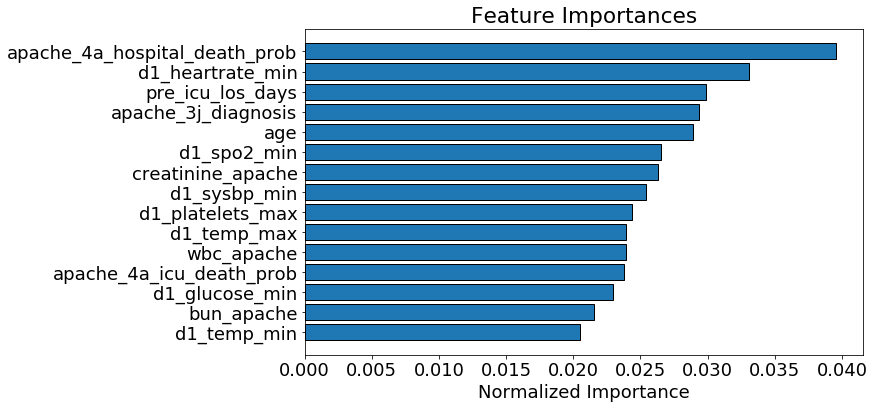

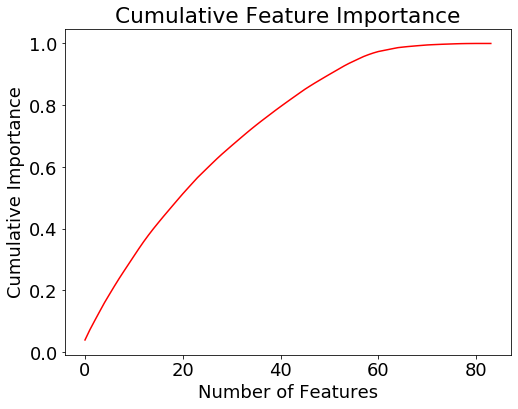

52 features required for 0.90 of cumulative importance


In [0]:
norm_feature_importances = plot_feature_importances(feature_importances)

In [0]:
feature_importances[:52]

feature  importance
64  apache_4a_hospital_death_prob       143.0
27               d1_heartrate_min       119.5
3                pre_icu_los_days       108.0
6             apache_3j_diagnosis       106.0
0                             age       104.5
33                    d1_spo2_min        96.0
9               creatinine_apache        95.0
35                   d1_sysbp_min        92.0
59               d1_platelets_max        88.0
23                     wbc_apache        86.5
36                    d1_temp_max        86.5
65       apache_4a_icu_death_prob        86.0
54                 d1_glucose_min        83.0
8                      bun_apache        78.0
37                    d1_temp_min        74.0
29                     d1_mbp_min        70.5
26               d1_heartrate_max        69.5
14                 glucose_apache        67.5
1                             bmi        67.5
31                d1_resprate_min        67.0
34                   d1_sysbp_max        66.5
58              d1_hemaglobin_min        63.5
30                d1_resprate_max        63.0
15              heart_rate_apache        62.5
19                resprate_apache        56.0
4                          weight        56.0
55                    d1_hco3_max        55.5
62                  d1_sodium_max        55.0
16              hematocrit_apache        52.5
18                     map_apache        50.0
5              apache_2_diagnosis        50.0
40               h1_heartrate_max        49.0
28                     d1_mbp_max        49.0
61               d1_potassium_min        48.5
45                h1_resprate_min        47.5
2                          height        46.0
41               h1_heartrate_min        45.0
57              d1_hemaglobin_max        43.5
56                    d1_hco3_min        43.5
21                    temp_apache        43.5
49                   h1_sysbp_min        42.0
48                   h1_sysbp_max        41.5
53                 d1_calcium_min        41.0
24                  d1_diasbp_max        40.5
43                     h1_mbp_min        40.5
38                  h1_diasbp_max        40.0
60               d1_potassium_max        36.5
25                  d1_diasbp_min        35.5
50                    h1_temp_max        34.0
47                    h1_spo2_min        34.0
63                  d1_sodium_min        33.5
39                  h1_diasbp_min        33.0

 Prueba F de Fisher --> (problema hay que elegir el nº de variables)

In [0]:
y=y.astype('int')

In [0]:
# Aplicando el algoritmo univariante de prueba F.
k = 52  # número de atributos a seleccionar
entrenar = clean_data.drop(['hospital_death'], axis=1)
columnas = list(entrenar.columns.values)
seleccionadas = SelectKBest(f_classif, k=k).fit(entrenar, y)
atrib = seleccionadas.get_support()
atributos = [columnas[i] for i in list(atrib.nonzero()[0])]
#atributos

C:\Users\viole\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning:

Features [ 7 12 88 89 91 92 93 94 95 98] are constant.

C:\Users\viole\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning:

invalid value encountered in true_divide



['age',
 'apache_2_diagnosis',
 'apache_3j_diagnosis',
 'bun_apache',
 'creatinine_apache',
 'gcs_eyes_apache',
 'gcs_motor_apache',
 'gcs_verbal_apache',
 'heart_rate_apache',
 'intubated_apache',
 'resprate_apache',
 'temp_apache',
 'ventilated_apache',
 'd1_diasbp_min',
 'd1_diasbp_noninvasive_min',
 'd1_heartrate_max',
 'd1_mbp_min',
 'd1_mbp_noninvasive_min',
 'd1_resprate_max',
 'd1_spo2_min',
 'd1_sysbp_min',
 'd1_sysbp_noninvasive_min',
 'd1_temp_min',
 'h1_diasbp_min',
 'h1_diasbp_noninvasive_min',
 'h1_heartrate_max',
 'h1_heartrate_min',
 'h1_mbp_min',
 'h1_mbp_noninvasive_min',
 'h1_resprate_max',
 'h1_resprate_min',
 'h1_spo2_min',
 'h1_sysbp_min',
 'h1_sysbp_noninvasive_min',
 'd1_bun_max',
 'd1_bun_min',
 'd1_calcium_min',
 'd1_creatinine_max',
 'd1_creatinine_min',
 'd1_glucose_max',
 'd1_hco3_max',
 'd1_hco3_min',
 'd1_wbc_max',
 'apache_4a_hospital_death_prob',
 'apache_4a_icu_death_prob',
 'apache_post_operative',
 'elective_surgery_0',
 'elective_surgery_1',
 'icu_a

Eliminación Recursiva de atributos --> tarda mazo  (Paralelizar ?)

In [0]:
modelo = ExtraTreesClassifier()
era = RFE(modelo, 52)  # número de atributos a seleccionar
era = era.fit(entrenar, y)

C:\Users\viole\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\viole\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\viole\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\viole\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\viole\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\viole\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value o

C:\Users\viole\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\viole\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\viole\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\viole\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\viole\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\viole\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value o

C:\Users\viole\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\viole\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\viole\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\viole\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\viole\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\viole\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value o

In [0]:
atrib = era.support_
atributos = [columnas[i] for i in list(atrib.nonzero()[0])]
#atributos

['age',
 'bmi',
 'pre_icu_los_days',
 'apache_2_diagnosis',
 'apache_3j_diagnosis',
 'bun_apache',
 'creatinine_apache',
 'gcs_eyes_apache',
 'gcs_verbal_apache',
 'heart_rate_apache',
 'resprate_apache',
 'ventilated_apache',
 'wbc_apache',
 'd1_diasbp_min',
 'd1_diasbp_noninvasive_min',
 'd1_heartrate_max',
 'd1_heartrate_min',
 'd1_mbp_min',
 'd1_mbp_noninvasive_max',
 'd1_mbp_noninvasive_min',
 'd1_resprate_max',
 'd1_resprate_min',
 'd1_spo2_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_sysbp_noninvasive_max',
 'd1_sysbp_noninvasive_min',
 'd1_temp_max',
 'd1_temp_min',
 'h1_diasbp_noninvasive_min',
 'h1_resprate_max',
 'h1_resprate_min',
 'h1_spo2_min',
 'h1_sysbp_min',
 'h1_temp_max',
 'd1_bun_max',
 'd1_bun_min',
 'd1_creatinine_max',
 'd1_glucose_max',
 'd1_glucose_min',
 'd1_hco3_max',
 'd1_hco3_min',
 'd1_hemaglobin_max',
 'd1_platelets_max',
 'd1_platelets_min',
 'd1_potassium_min',
 'd1_sodium_max',
 'd1_wbc_min',
 'apache_4a_hospital_death_prob',
 'apache_4a_icu_death_prob

#### Clasificadores

In [0]:
X_train, X_test, y_train, y_test = train_test_split(clean_data, y, test_size=0.2, random_state=0)

LDA (Fisher)

1. Datos desbalanceados

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis(n_components=2)
clf.fit(X_train, y_train)

C:\Users\viole\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning:

n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(106, 2 - 1) = 1 components.

C:\Users\viole\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning:

In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).

C:\Users\viole\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning:

Variables are collinear.



LinearDiscriminantAnalysis(n_components=2, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [0]:
y_pred=clf.predict(X_test)

In [0]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print("Accuracy normalizando:",metrics.accuracy_score(y_test,y_pred))
print(cnf_matrix)

Accuracy normalizando: 0.9174071853022951
[[16211   461]
 [ 1054   617]]


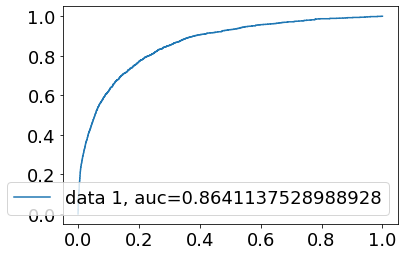

In [0]:
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

2. Datos balanceados

In [0]:

desbal = NearMiss(ratio=1, n_neighbors=3, version=2, random_state=2)
X_train_res, y_train_res = desbal.fit_sample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

ImportError: cannot import name '_to_object_array' from 'sklearn.utils' (C:\Users\viole\Anaconda3\lib\site-packages\sklearn\utils\__init__.py)

#### Correlation Map

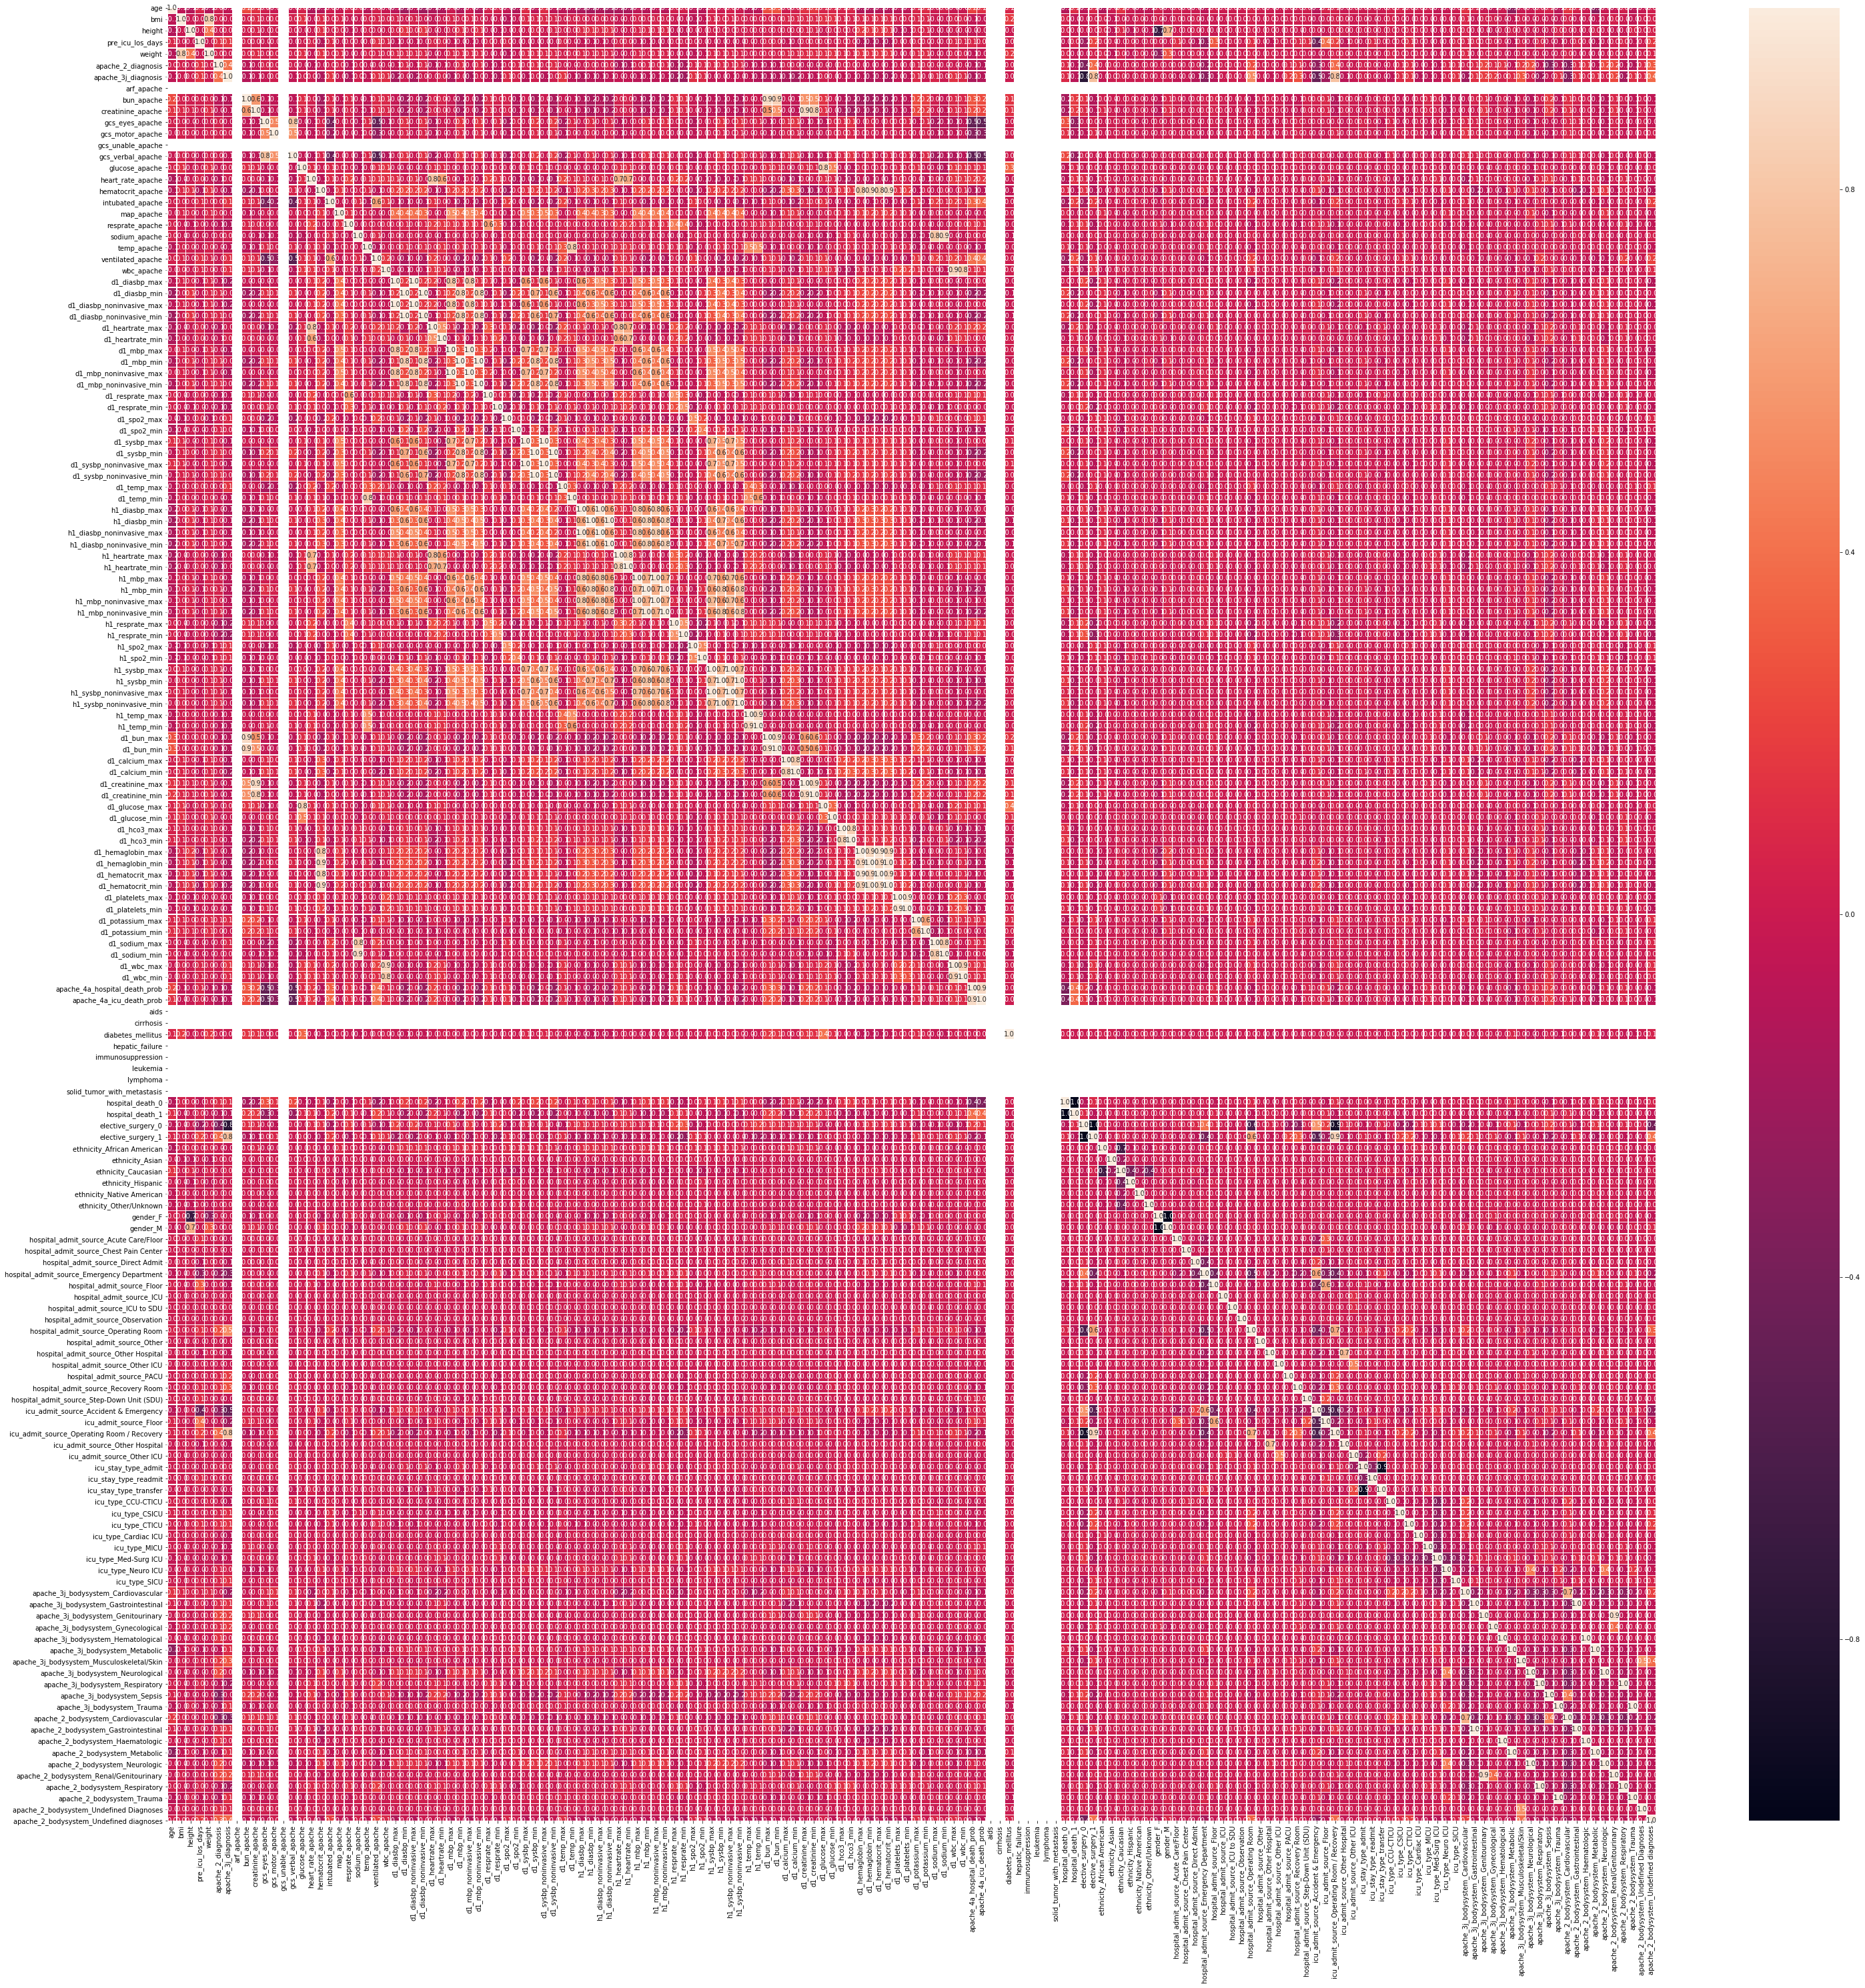

In [0]:
#correlation map
f,ax = plt.subplots(figsize=(50, 50))
sns.heatmap(clean_data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

In [0]:
def matriz_confusion(cnf):
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')